In [1]:
import numpy as np
from numpy.fft import fft2, ifft2, fftshift, ifftshift
import cv2
import matplotlib.pyplot as plt

### <font color='aqua'>Windmill </font>

In [12]:
def clean_windmill(im):
	# Compute the 2D Fourier Transform
	f = fft2(im)
	fshift = fftshift(f)
	
	# Get the magnitude spectrum
	magnitude_spectrum = np.log(np.abs(fshift) + 1)
	
	# Display the magnitude spectrum
	# plt.figure(figsize=(5, 5))
	# plt.imshow(magnitude_spectrum, cmap='gray')
	# plt.title('Magnitude Spectrum')
	# plt.show()
	
	rows, cols = im.shape
	crow, ccol = rows // 2 , cols // 2
	
	# Find abnormally large coefficients in the magnitude spectrum
	mask = np.ones((rows, cols), np.uint8)
	threshold = 200000
	for i in range(rows):
		for j in range(cols):
			# Skip the center of the magnitude spectrum (radius 10)
			if (i - crow)**2 + (j - ccol)**2 <= 10**2:
				continue
			# Check if the magnitude of the Fourier coefficient is greater than the threshold
			if np.abs(fshift[i, j]) > threshold:
				mask[i, j] = 0
	
	# Apply the mask
	fshift = fshift * mask

	# masked_magnitude_spectrum = np.log(np.abs(fshift) + 1)
	# plt.figure(figsize=(5, 5))
	# plt.imshow(masked_magnitude_spectrum, cmap='gray')
	# plt.title('Masked Magnitude Spectrum')
	# plt.show()
	
	# Inverse Fourier Transform to get the cleaned image
	f_ishift = ifftshift(fshift)
	img_back = ifft2(f_ishift)
	img_back = np.abs(img_back)
	
	return img_back

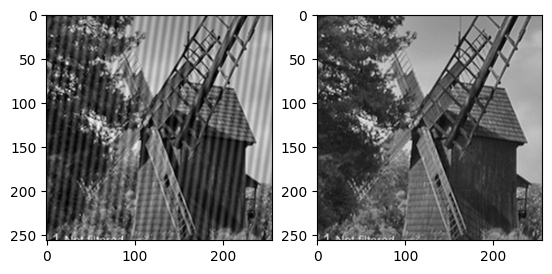

In [13]:
im2 = cv2.imread(r'Images/windmill.tif')
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
im2_clean = clean_windmill(im2)

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(im2, cmap='gray', vmin=0, vmax=255)
plt.subplot(1, 2, 2)
plt.imshow(im2_clean, cmap='gray', vmin=0, vmax=255)

### <font color = 'aqua'>Umbrella </font>

In [2]:
def construct_degradation_kernel(shape, shift):
    # builds a degragation kernel with a predetermined shift
    kernel = np.zeros(shape)
    kernel[0, 0] = 1                # Unshifted component
    kernel[shift[0], shift[1]] = 1  # Shifted component
    return kernel / 2               # Normalize to preserve energy

def clean_umbrella(im , custom_shift = (0,0)):
    # application of the simpler filter inverse
    lam = 0.0001
    
    # Construct kernel
    h = construct_degradation_kernel(im.shape, custom_shift)

    g = im

    G = fft2(g)
    H = fft2(h)
    H_conj = np.conjugate(H)

    F = (H_conj / (H*H_conj + lam))*G
    f = ifft2(F)

    return np.real(f)

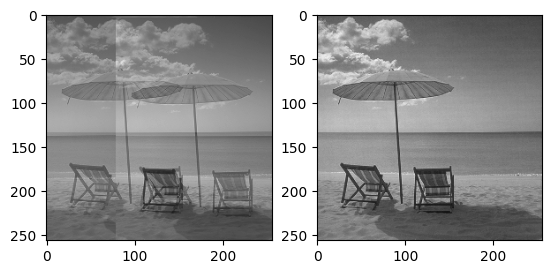

In [3]:
im4 = cv2.imread(r'Images/umbrella.tif')
im4 = cv2.cvtColor(im4, cv2.COLOR_BGR2GRAY)
im4_clean = clean_umbrella(im4, custom_shift=(4,79))

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(im4, cmap='gray', vmin=0, vmax=255)
plt.subplot(1, 2, 2)
plt.imshow(im4_clean, cmap='gray', vmin=0, vmax=255)

### <font color = 'aqua'> Watermelon</font>

In [46]:
def clean_watermelon(im):
    # sharpen image
    kernel = np.array([[-1, -1, -1, -1, -1],
                       [-1,  2,  2,  2, -1],
                       [-1,  2,  8,  2, -1],
                       [-1,  2,  2,  2, -1],
                       [-1, -1, -1, -1, -1]]) / 8.0
    im_sharpened = cv2.filter2D(im, -1, kernel)
    return im_sharpened


In [ ]:
im3 = cv2.imread(r'Images\watermelon.tif')
im3 = cv2.cvtColor(im3, cv2.COLOR_BGR2GRAY)
im3_clean = clean_watermelon(im3)

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(im3, cmap='gray', vmin=0, vmax=255)
plt.subplot(1, 2, 2)
plt.imshow(im3_clean, cmap='gray', vmin=0, vmax=255)

### <font color = 'aqua'> Flag</font>

In [169]:
def get_neighbors(image, row, col):
    neighbors = []
    
    # Add the 2 left pixels if valid
    for i in range(1, 7):
        if col - i >= 0:
            neighbors.append(image[row, col - i])
        else:
            neighbors.append(0)  # out-of-bounds
    
    # Add the current pixel
    neighbors.append(image[row, col])
    
    # Add the 2 right pixels if valid
    for i in range(1, 7):
        if col + i < image.shape[1]:
            neighbors.append(image[row, col + i])
        else:
            neighbors.append(0)  # out-of-bounds
    
    return neighbors

def clean_USAflag(image):
    # application of median filter HORIZONTALLY starting at predetermined thresholds 
    filtered_image = np.copy(image)
    
    # Apply horizontal median filter only to rows > 75 and cols > 120
    for x in range(image.shape[0]):  # Iterate over each row
        if x < 85:
            for y in range(140, image.shape[1]): 
                filtered_image[x, y] = np.median(get_neighbors(image, x, y))
        else:
            for y in range(image.shape[1]):
                filtered_image[x, y] = np.median(get_neighbors(image, x, y))
            
    return filtered_image

In [ ]:
im5 = cv2.imread(r'Images\USAflag.tif')
im5 = cv2.cvtColor(im5, cv2.COLOR_BGR2GRAY)
im5_clean = clean_USAflag(im5)

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(im5, cmap='gray', vmin=0, vmax=255)
plt.subplot(1, 2, 2)
plt.imshow(im5_clean, cmap='gray', vmin=0, vmax=255)

### <font color = 'salmon'> House</font>

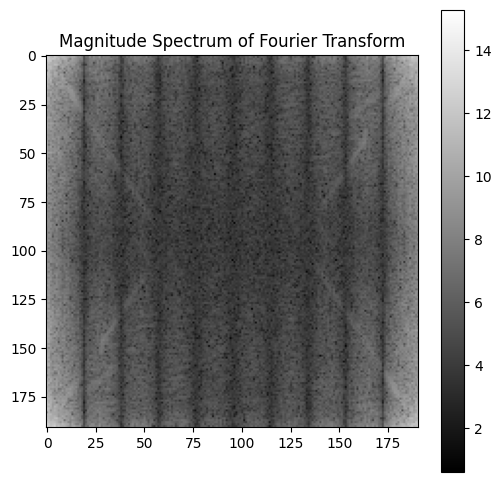

In [5]:
def fourier_mag(im):
    f = fft2(im)
    fshift = fftshift(f)

    magnitude_spectrum = np.log(np.abs(f) + 1)
    return magnitude_spectrum

im6 = cv2.imread(r'Images/house.tif')
im6 = cv2.cvtColor(im6, cv2.COLOR_BGR2GRAY)
magnitude_spectrum = fourier_mag(im6)

# Plot the magnitude spectrum
plt.figure(figsize=(6, 6))
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum of Fourier Transform')
plt.colorbar()
plt.show()

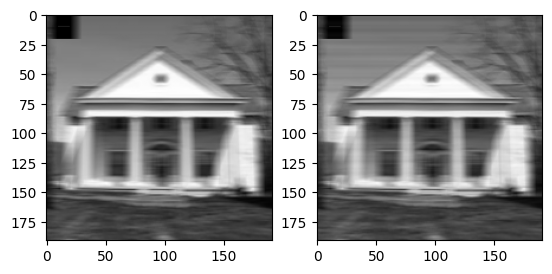

In [21]:
def construct_averaging_kernel(shape, num_images=10):
    kernel = np.ones(shape) * (1 / num_images)  # Uniform averaging kernel
    kernel[0, 0] += 1 - (1 / num_images)        # Adjust to preserve energy at the DC component
    return kernel

def clean_blurred_image_frequency(im, num_images=10, lam=0.0001):
    # Step 1: Perform FFT and shift for visualization
    fshift = fftshift(fft2(im))
    
    # Step 2: Detect and reduce periodic frequency peaks
    rows, cols = im.shape
    crow, ccol = rows // 2, cols // 2
    
    # Assume peaks repeat at intervals related to `num_images`
    peak_spacing = cols // num_images  # Adjust for more accurate spacing if needed
    for i in range(-3, 4):  # Number of peak repetitions to suppress
        if i == 0:
            continue  # Skip the central peak (low frequency)
        for j in range(-3, 4):  # Consider a range of directions for artifacts
            x, y = ccol + i * peak_spacing, crow + j * peak_spacing
            if 0 <= x < cols and 0 <= y < rows:
                fshift[x, y] *= lam  # Suppress periodic peaks
    
    # Step 3: Inverse FFT to restore image
    f_restored = ifft2(ifftshift(fshift))
    restored_image = np.real(f_restored)
    
    return restored_image


im6 = cv2.imread(r'Images/house.tif')
im6 = cv2.cvtColor(im6, cv2.COLOR_BGR2GRAY)
im6_clean = clean_blurred_image_frequency(im6)

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(im6, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(im6_clean, cmap='gray')

In [ ]:
im6 = cv2.imread(r'Images\house.tif')
im6 = cv2.cvtColor(im6, cv2.COLOR_BGR2GRAY)
im6_clean = clean_house(im6)

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(im6, cmap='gray', vmin=0, vmax=255)
plt.subplot(1, 2, 2)
plt.imshow(im6_clean, cmap='gray', vmin=0, vmax=255)

### <font color = 'salmon'> Bears</font>

In [ ]:
im7 = cv2.imread(r'Images\bears.tif')
im7 = cv2.cvtColor(im7, cv2.COLOR_BGR2GRAY)
im7_clean = clean_bears(im7)

plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(im7, cmap='gray', vmin=0, vmax=255)
plt.subplot(1, 2, 2)
plt.imshow(im7_clean, cmap='gray', vmin=0, vmax=255)

plt.show()